## Cloud observations

This notebook simulates microwave and sub-mm observations of idealized clouds in the atmosphere. Its purpose is to illustrate the general radiative properties of clouds observed from space- or airborne remote sensing instruments.

The simulations are performed using the [parts](https://github.com/simonpf/parts) package, which provides a high-level interface to the [Atmospheric Radiative Transfer Simulator (ARTS)](https://www.radiative-transfer.org).

In [1]:
from parts.utils.notebook_setup import *

Loading ARTS API from: /home/simonpf/build/arts_fast/src/libarts_api.so


## Sensors

Simulations are performed for selected channels from the ICI and MWI passive radiometers.

In [2]:
from parts.sensor import MWI, ICI

mwi = MWI(stokes_dimension = 1, channel_indices = [2, 7, 9, 12, 15])
mwi.sensor_line_of_sight = np.array([180.0])
mwi.sensor_position      = np.array([500e3])

ici = ICI(stokes_dimension = 1, channel_indices = [1, 3, 5, 8, 10])
ici.sensor_line_of_sight = np.array([180.0])
ici.sensor_position      = np.array([500e3])

sensors = [ici, mwi]

Optionally, simulations can also be performed for the CloudSat cloud radar.

In [3]:
from parts.sensor import CloudSat

cloud_sat = CloudSat(stokes_dimension = 1)
cloud_sat.sensor_line_of_sight = np.array([180.0])
cloud_sat.sensor_position      = np.array([500e3])
cloud_sat.range_bins           = np.linspace(0, 20e3, 41) # Edges of range bins [m]

# Uncomment to include CloudSat in simulation.
sensors += [cloud_sat]

## Atmosphere

The following assumptions are made for the radiative transfer calculations:
- One-dimensional atmosphere
- Observations over ocean
- Background atmosphere consisting of oxygen, nitrogen and water vapor

These assumptions are implemented by the `StandardAtmosphere` preconfigured atmosphere model
provided by `parts`.

In [4]:
%load_ext autoreload
%autoreload 2
from parts.models import StandardAtmosphere
atmosphere = StandardAtmosphere()

### Atmospheric data

To perform a numeric simulation, in addition to the abstract description of the atmsopheric configuration to be simulated, the specific atmospheric state (i.e. temperature, pressure, and so on) must be known.

For this `parts` provides standard data providers that provide climatological data for typical atmospheric regime.
Here the `Tropical` data provider is used that provides data describing a typical tropical atmosphere.

In [5]:
from parts.data.atmosphere import Tropical
z = np.linspace(0, 20e3, 41)
data_provider = Tropical(z = z)

To illustrate this we can plot the data defining the atmospheric state that is provided by the data provider.

In [6]:
p   = data_provider.get_pressure()
t   = data_provider.get_temperature()
q   = data_provider.get_H2O()

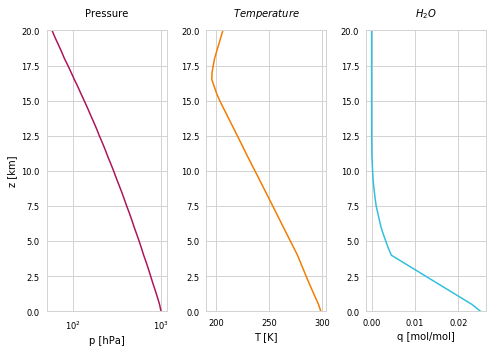

In [7]:
f, axs = plt.subplots(1, 3, figsize = (7, 5))

ax = axs[0]
ax.plot(p / 100, z / 1e3, c = "C0")
ax.set_xscale("log")
ax.set_xlabel("p [hPa]")
ax.set_ylabel("z [km]")
ax.set_ylim([0, 20])
ax.set_title("Pressure")

ax = axs[1]
ax.plot(t, z / 1e3, c = "C1")
ax.set_xlabel("T [K]")
ax.set_ylim([0, 20])
ax.set_title("$Temperature$")

ax = axs[2]
ax.plot(q, z / 1e3, c = "C2")
ax.set_xlabel("q [mol/mol]")
ax.set_ylim([0, 20])
ax.set_title("$H_2O$")

plt.tight_layout()

## Clear sky calculations

To determine the effect of clouds in the atmospheric column, we start with calculating clear-sky radiances as reference value. To run the simulation

In [8]:
from parts.simulation import ArtsSimulation
simulation = ArtsSimulation(atmosphere = atmosphere,
                            sensors = sensors,
                            data_provider = data_provider)
simulation.setup(verbosity = 0)
simulation.run()

The results of the simulation can be accessed via the `y` attribute of the sensors used in the simulation. To store the values for lates use, the have to be explicitly copied otherwise they will be overwritten by the next simulation.

In [9]:
f_ici       = np.copy(ici.f_grid)
y_ici_clear = np.copy(ici.y)

f_mwi       = np.copy(mwi.f_grid)
y_mwi_clear = np.copy(mwi.y)

y_cs_clear = np.copy(cloud_sat.y)
z_cs       = cloud_sat.range_bins
z_cs       = 0.5 * (z_cs[1:] + z_cs[:-1])

### Results

Here we simply plot the results from the clear sky simulation.

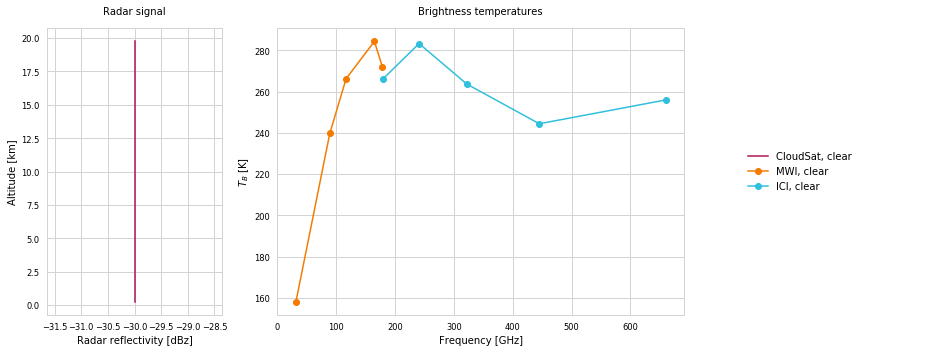

In [10]:
from matplotlib.gridspec import GridSpec
f = plt.figure(figsize = (13, 5))
gs = GridSpec(1, 4)

handles = []
labels  = []

#
# Radar
#

ax = plt.subplot(gs[0, 0])

handles += ax.plot(y_cs_clear, z_cs / 1e3, c = "C0")
labels  += ["CloudSat, clear"]

ax.set_xlabel("Radar reflectivity [dBz]")
ax.set_ylabel("Altitude [km]")
ax.set_title("Radar signal")

#
# Passive
#

ax = plt.subplot(gs[0, 1:3])

handles += ax.plot(f_mwi / 1e9, y_mwi_clear, c = "C1", marker = "o")
labels  += ["MWI, clear"]
handles += ax.plot(f_ici / 1e9, y_ici_clear, c = "C2", marker = "o")
labels  += ["ICI, clear"]

ax.set_title("Brightness temperatures")
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("$T_B$ [K]")

#
# Legend
#

ax = plt.subplot(gs[0, -1])

ax.legend(handles = handles, labels = labels, loc = "center left")
ax.set_axis_off()

plt.tight_layout()

## Adding clouds to the simulation

To additional steps are required to take into account clouds in the simulation:

- Add scattering species to the atmosphere model
- Provide the data describing the specific state of the clouds

In [11]:
from parts.scattering.ssdb import shapes
display(shapes)

[8-ColumnAggregate,
 EvansSnowAggregate,
 6-BulletRosette,
 SectorSnowflake,
 LiquidSphere,
 LargePlateAggregate]

### Scattering species

Since their most important interaction with radiation in the microwave region that we are interested in is through scattering, we clouds are represented in the atmosphere model as **scattering species**.

To define a scattering species, we must specify
- a particle shape
- a particle size distribution (PSD)

### Available shapes

`parts` provides some predefined particle shapes from the [ARTS single scattering database](https://zenodo.org/record/1175573).

In [12]:
from parts.scattering.ssdb import shapes
display(shapes)

[8-ColumnAggregate,
 EvansSnowAggregate,
 6-BulletRosette,
 SectorSnowflake,
 LiquidSphere,
 LargePlateAggregate]

### Particle size distribution

As particle size distribution we will be using the `D14N` PSD, which is a modified gamma distribution parametrized by the **mass density** and a vertical scaling factor or **intercept parameter** $N_0^*$.

#### Liquid

So to define a liquid cloud species we simply create a scattering species with a PSD and the liquid sphere shape.

For liquid clouds it is also necessary to set a temperature minimum for the PSD below which the PSD will be zero. The reason for this is that the scattering properties for the liquid shape are not available at low temperatures.

In [14]:
from parts.scattering import ScatteringSpecies
from parts.scattering.psd import D14MN
psd   = D14MN(alpha = 2.0,    # first shape parameter
              beta  = 1.0,    # second shape parameter
              rho   = 1000.0) # density [kg/m^3]
psd.t_min = 270.0
shape = shapes[-2] # Liquid sphere
liquid_cloud = ScatteringSpecies("liquid_cloud", psd, shape)

To illustrate this we can plot the particle shape and the PSD for different parameter values.

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


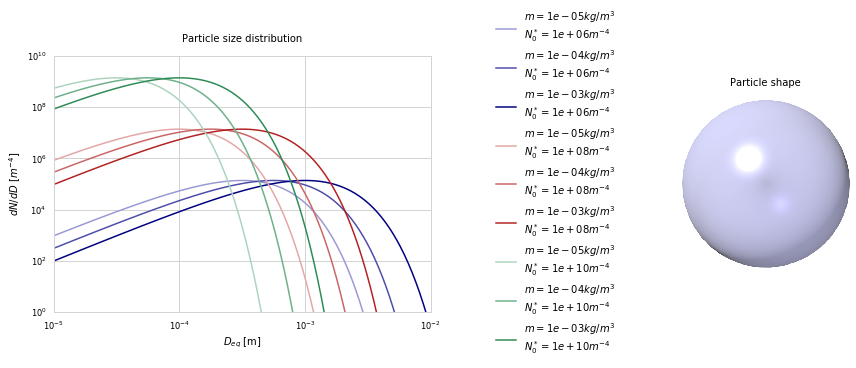

In [15]:
import matplotlib.image as mi
import seaborn as sns

#
# Some colors.
#

sns.reset_orig()
cs = [sns.light_palette("navy", 4),
      sns.light_palette("firebrick", 4),
      sns.light_palette("seagreen", 4)]

#
# Figure setup
#

f  = plt.figure(figsize = (12, 5))
gs = GridSpec(1, 4)

# PSD plots.
ax = plt.subplot(gs[0, 0:2])
x  = np.logspace(-5, -2, 101)
handles = []
labels  = []
for j, n0 in enumerate(np.array([1e6, 1e8, 1e10])):
    for i, md in enumerate(np.array([1e-5, 1e-4, 1e-3])):
        psd.mass_density = md
        psd.intercept_parameter = n0
        y = psd.evaluate(x).data.ravel()
        handles += ax.plot(x, y, c = cs[j][1 + i])
        labels += [r"$m = {0:.0e} kg / m^3$"
                   " \n"
                   r"$N_0^* = {1:.0e} m^{{-4}}$".format(md, n0)]

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim([1e0, 1e10])
ax.set_xlim([1e-5, 1e-2])
ax.set_xlabel("$D_{eq}$ [m]")
ax.set_ylabel("$dN/dD$ [$m^{-4}$]")
ax.set_title("Particle size distribution")

# Legend.
ax  = plt.subplot(gs[0, 2])
ax.legend(handles = handles, labels = labels, ncol = 1, loc = "center")
ax.set_axis_off()


# Shape image.
ax  = plt.subplot(gs[0, 3])
img = mi.imread(shape.img)
ax.imshow(img)
ax.set_aspect(1)
ax.set_axis_off()
ax.set_title("Particle shape")

plt.tight_layout()

### Ice

For ice we obviously choose a different particle shape and also modify the PSD shape a bit.

As for liquid clouds, for ice clouds it is necessary to set a **temperature maximum** for the PSD above which the PSD will be zero. The reason for this is that the scattering properties for the liquid shape are not available at low temperatures.

In [16]:
psd   = D14MN(alpha = -1.0,   # first shape parameter
              beta  = 3.0,    # second shape parameter
              rho   = 917.0) # density [kg/m^3]
psd.t_max = 280.0
shape = shapes[0] # Evans snow aggregate
ice_cloud = ScatteringSpecies("ice_cloud", psd, shape)

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


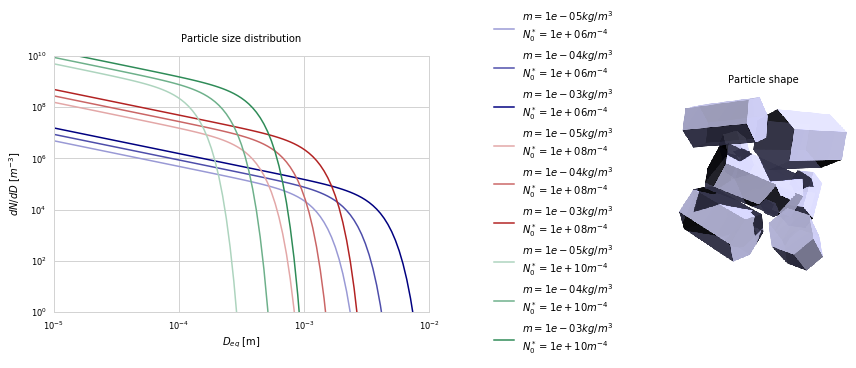

In [17]:
import matplotlib.image as mi
import seaborn as sns

#
# Some colors.
#

sns.reset_orig()
cs = [sns.light_palette("navy", 4),
      sns.light_palette("firebrick", 4),
      sns.light_palette("seagreen", 4)]

#
# Figure setup
#

f  = plt.figure(figsize = (12, 5))
gs = GridSpec(1, 4)

# PSD plots.
ax = plt.subplot(gs[0, 0:2])
x  = np.logspace(-5, -2, 101)
handles = []
labels  = []
for j, n0 in enumerate(np.array([1e6, 1e8, 1e10])):
    for i, md in enumerate(np.array([1e-5, 1e-4, 1e-3])):
        psd.mass_density = md
        psd.intercept_parameter = n0
        y = psd.evaluate(x).data.ravel()
        handles += ax.plot(x, y, c = cs[j][1 + i])
        labels += [r"$m = {0:.0e} kg / m^3$"
                   " \n"
                   r"$N_0^* = {1:.0e} m^{{-4}}$".format(md, n0)]

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim([1e0, 1e10])
ax.set_xlim([1e-5, 1e-2])
ax.set_xlabel("$D_{eq}$ [m]")
ax.set_ylabel("$dN/dD$ [$m^{-3}$]")
ax.set_title("Particle size distribution")

# Legend.
ax  = plt.subplot(gs[0, 2])
ax.legend(handles = handles, labels = labels, ncol = 1, loc = "center")
ax.set_axis_off()


# Shape image.
ax  = plt.subplot(gs[0, 3])
img = mi.imread(shape.img)
ax.imshow(img)
ax.set_aspect(1)
ax.set_axis_off()
ax.set_title("Particle shape")

plt.tight_layout()

### Cloud data

To simulate a specific cloud configuration, we need to specify the PSD parameters for each scattering species for the atmospheric column. We do this by defining a `CloudDataProvider` class that generates 1D Gaussian clouds.

In [28]:
class CloudDataProvider:
    def __init__(self, name, z, mass_density = 1e-4, center = 10e3, thickness = 1e3):
        self.z = z 
        self.mass_density = mass_density
        self.center = center
        self.thickness = thickness
        
        self.name = name
        self.__dict__["get_" + name + "_mass_density"] = self.get_mass_density
        self.__dict__["get_" + name + "_intercept_parameter"] = self.get_intercept_parameter
    
    def get_mass_density(self):
        md = self.mass_density * np.exp(- ((z - self.center) / self.thickness) ** 2)
        md[md < 1e-8] = 0.0
        return md
    
    def get_intercept_parameter(self):
        return 1e8 * np.ones(z.shape)
    
liquid_cloud_data = CloudDataProvider("liquid_cloud", z, mass_density = 1e-4, center = 3e3)
ice_cloud_data    = CloudDataProvider("ice_cloud", z, mass_density = 5e-4, center = 12e3, thickness = 1.5e3)

Let's plot this to see how the clouds look.

#### Liquid

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100000000.0, right=100000000.0
  self.set_xlim(upper, lower, auto=None)


Text(0.5, 0, '$D_{eq}$ [m]')

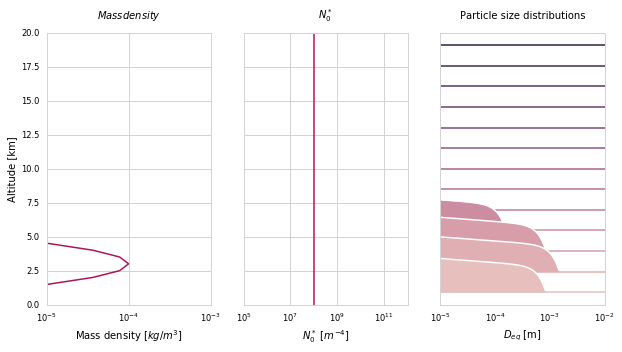

In [29]:
from parts.utils.plots import plot_psds
f, axs = plt.subplots(1, 3, figsize = (10, 5))

md = liquid_cloud_data.get_liquid_cloud_mass_density()
ax = axs[0]
ax.plot(md, z / 1e3)
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e-5, 1e-3])
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Mass density [$kg / m^3$]")
ax.set_title("$Mass density$")

n0 = liquid_cloud_data.get_liquid_cloud_intercept_parameter()
ax = axs[1]
ax.plot(n0, z / 1e3)
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e5, 1e12])
ax.set_title("$N_0^*$")
ax.set_xlabel("$N_0^*$ $[m^{-4}]$")
ax.yaxis.set_ticklabels([])

x = np.logspace(-5, -2, 101)
psd.mass_density = md
psd.intercept_parameter = n0
y = psd.evaluate(x).data.T
ax = axs[2]
plot_psds(x, y[:, ::3], z[::3] / 1e3, 0.3, 0, ax)
ax.set_xlim([1e-5, 1e-2])
ax.yaxis.set_ticks([])
ax.set_title("Particle size distributions")
ax.set_xlabel("$D_{eq}$ [m]")

### Ice cloud

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100000000.0, right=100000000.0
  self.set_xlim(upper, lower, auto=None)


Text(0.5, 0, '$D_{eq}$ [m]')

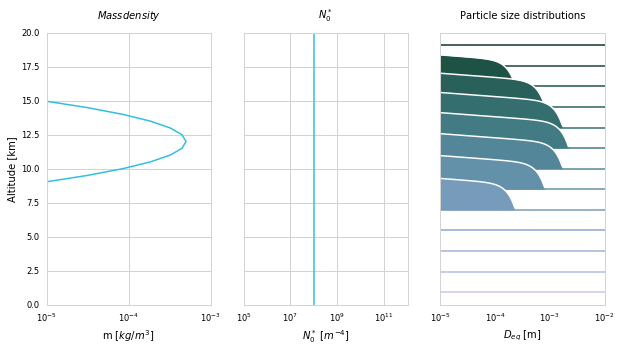

In [31]:
from parts.utils.plots import plot_psds
f, axs = plt.subplots(1, 3, figsize = (10, 5))

md = ice_cloud_data.get_ice_cloud_mass_density()
ax = axs[0]
ax.plot(md, z / 1e3, c = "C2")
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e-5, 1e-3])
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("m [$kg / m^3$]")
ax.set_title("$Mass density$")

n0 = ice_cloud_data.get_ice_cloud_intercept_parameter()
ax = axs[1]
ax.plot(n0, z / 1e3, c = "C2")
ax.set_xscale("log")
ax.set_ylim([0, 20])
ax.set_xlim([1e5, 1e12])
ax.set_title("$N_0^*$")
ax.set_xlabel("$N_0^*$ $[m^{-4}]$")
ax.yaxis.set_ticklabels([])

x = np.logspace(-5, -2, 101)
psd.mass_density = md
psd.intercept_parameter = n0
y = psd.evaluate(x).data.T
ax = axs[2]
plot_psds(x, y[:, ::3], z[::3] / 1e3, 0.3, 2, ax)
ax.set_xlim([1e-5, 1e-2])
ax.yaxis.set_ticks([])
ax.set_title("Particle size distributions")
ax.set_xlabel("$D_{eq}$ [m]")

## Simulating cloudy-sky radiances

To simulate the cloudy atmosphere all that is left to do is:
- Add scattering species to atmosphere model
- Combine data provider for tropical background atmosphere with cloud data providers

In [32]:
from parts.data_provider import CombinedProvider
atmosphere.scatterers     = [liquid_cloud, ice_cloud]
data_provider_cloudy      = CombinedProvider(data_provider, liquid_cloud_data, ice_cloud_data)

### Run the simulation

In [34]:
simulation.data_provider = data_provider_cloudy
simulation.setup(verbosity = 0)
simulation.run()

In [35]:
y_ici_cloud = np.copy(ici.y)
y_mwi_cloud = np.copy(mwi.y)
y_cs_cloud  = np.copy(cloud_sat.y)

## Results

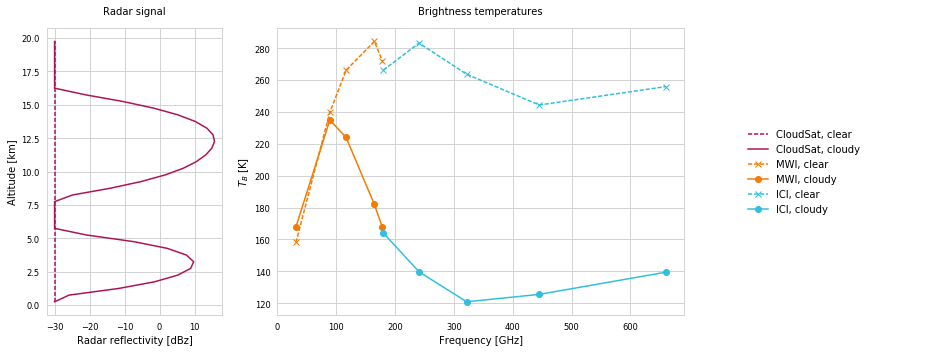

In [36]:
from matplotlib.gridspec import GridSpec
f = plt.figure(figsize = (13, 5))
gs = GridSpec(1, 4)

handles = []
labels  = []

#
# Radar
#

ax = plt.subplot(gs[0, 0])

handles += ax.plot(y_cs_clear, z_cs / 1e3, c = "C0", ls = "--")
labels  += ["CloudSat, clear"]
handles += ax.plot(y_cs_cloud, z_cs / 1e3, c = "C0")
labels  += ["CloudSat, cloudy"]

ax.set_xlabel("Radar reflectivity [dBz]")
ax.set_ylabel("Altitude [km]")
ax.set_title("Radar signal")

#
# Passive
#

ax = plt.subplot(gs[0, 1:3])

handles += ax.plot(f_mwi / 1e9, y_mwi_clear, c = "C1", marker = "x", ls = "--")
labels  += ["MWI, clear"]
handles += ax.plot(f_mwi / 1e9, y_mwi_cloud, c = "C1", marker = "o")
labels  += ["MWI, cloudy"]
handles += ax.plot(f_ici / 1e9, y_ici_clear, c = "C2", marker = "x", ls = "--")
labels  += ["ICI, clear"]
handles += ax.plot(f_ici / 1e9, y_ici_cloud, c = "C2", marker = "o")
labels  += ["ICI, cloudy"]

ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("$T_B$ [K]")
ax.set_title("Brightness temperatures")

#
# Legend
#

ax = plt.subplot(gs[0, -1])

ax.legend(handles = handles, labels = labels, loc = "center left")
ax.set_axis_off()

plt.tight_layout()